In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm

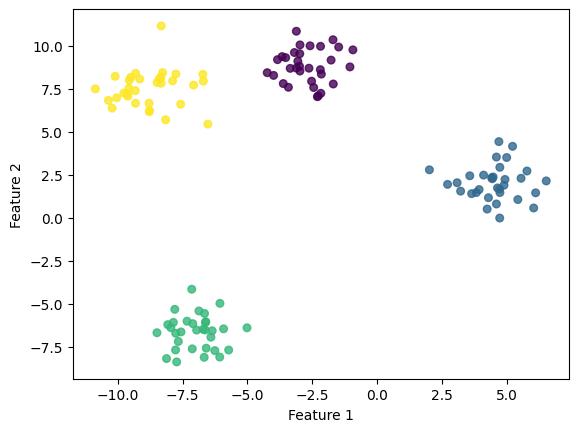

array([7.36701345e-05, 2.26035481e-03, 9.02032862e-02, 1.13133460e+01])

In [3]:
# data generation
X, Y = datasets.make_blobs(n_samples=128, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)

# eigendecomposition for reference
inv_val, inv_vec = eigh(normalize(L_inv))
inv_val[-4:]

In [4]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))

hermitian :  True True True
unitary :  False False False
unitary :  True True True


8208


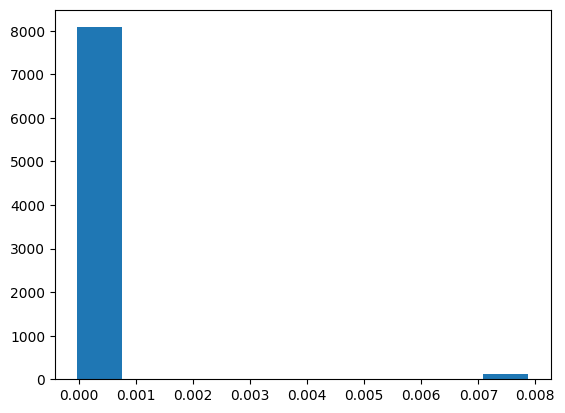

In [5]:
# quantum power method based on the blaock encoding
L_dec = qml.pauli_decompose(L_inv_norm)
coeff, op = L_dec.terms()
print(len(L_dec))

plt.hist(coeff)
plt.show()

In [6]:
sum(coeff > 0.007)

128

In [7]:
red_idx = []
for idx, val in enumerate(coeff):
    if val>0.007:
        red_idx.append(idx)
        
coeff_red = [coeff[i] for i in red_idx]
op_red = [op[i] for i in red_idx]
len(coeff_red)

128

In [8]:
dev = qml.device("default.qubit", wires=14) 
reg = qml.registers({"control": 7, "target": 7}) 
norm_coeff = (np.sqrt(coeff_red) / np.linalg.norm(np.sqrt(coeff_red)))
scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op, {i: i + 7 for i in range(7)}) for op in op_red]

def block_encoding_L_inverse():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def power_method(num_iter=2):
    for _ in range(num_iter):
        block_encoding_L_inverse()
    return qml.state()

In [ ]:
output_matrix = qml.matrix(power_method)()
print(np.real(np.round(output_matrix,2)))